## This program is made to track the rigid body variablity across the experimental protocol

In [1]:
# Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
sys.path.insert(0,'/Users/ashwin/Documents/Y4 project Brain Human Interfaces/General 4th year Github repo/BrainMachineInterfaces')

# Set the save game location
# Must have format of "../PointerExperimentData/Name_dd_mm__hh_mm_metadata" with no file extension
# saveFile = "../PointerExperimentData/Ashwin_13_02"
# saveGameLocation = saveFile + "/Ash_13_02_13_19" # must have format of "Name_dd_mm__hh_mm_metadata" with no file extension

from Experiment_pointer.runFullExperiment import saveDirectory, saveGameLocation

saveFile = saveDirectory

# Replace Experiment pointer with .. as notebook runs from another directory
saveFile = saveFile.replace("Experiment_pointer","..")
saveGameLocation = saveGameLocation.replace("Experiment_pointer","..")
path = "/Users/ashwin/Documents/Y4 project Brain Human Interfaces/General 4th year Github repo/BrainMachineInterfaces/Experiment_pointer/DataAnalysis"
os.chdir(path)

from Experiment_pointer.experimentFunctions import processTrialData
DOFOffset = 0.03
from sklearn.decomposition import PCA
from lib_streamAndRenderDataWorkflows.config_streaming import bodyParts


pygame 2.5.2 (SDL 2.28.3, Python 3.11.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
# Fetch all trial information


rigidBodies1, cursorPos1,cursorVel1,goCues1,targetHits1,timeStamps1, minDof1,maxDof1,d,targetFailedAppearTimes1 = processTrialData(saveGameLocation + "_training1",DOFOffset)
rigidBodies2, cursorPos2,cursorVel2,goCues2,targetHits2,timeStamps2, minDof2,maxDof2,e,targetFailedAppearTimes2 = processTrialData(saveGameLocation + "_training2",DOFOffset)
rigidBodies3, cursorPos3,cursorVel3,goCues3,targetHits3,timeStamps3, minDof3,maxDof3,f,targetFailedAppearTimes3 = processTrialData(saveGameLocation + "_training3",DOFOffset)
rigidBodies4, cursorPos4,cursorVel4,goCues4,targetHits4,timeStamps4, minDof4,maxDof4,g,targetFailedAppearTimes4 = processTrialData(saveGameLocation + "_training4",DOFOffset)
rigidBodies5, cursorPos5,cursorVel5,goCues5,targetHits5,timeStamps5, minDof5,maxDof5,h,targetFailedAppearTimes5 = processTrialData(saveGameLocation + "_test",DOFOffset)# make this test 

/Users/ashwin/Documents/Y4 project Brain Human Interfaces/General 4th year Github repo/BrainMachineInterfaces/Experiment_pointer/DataAnalysis
/Users/ashwin/Documents/Y4 project Brain Human Interfaces/General 4th year Github repo/BrainMachineInterfaces/Experiment_pointer/DataAnalysis
/Users/ashwin/Documents/Y4 project Brain Human Interfaces/General 4th year Github repo/BrainMachineInterfaces/Experiment_pointer/DataAnalysis
/Users/ashwin/Documents/Y4 project Brain Human Interfaces/General 4th year Github repo/BrainMachineInterfaces/Experiment_pointer/DataAnalysis
/Users/ashwin/Documents/Y4 project Brain Human Interfaces/General 4th year Github repo/BrainMachineInterfaces/Experiment_pointer/DataAnalysis


In [3]:


def extractPCAFromRigidBodies(rigidBodyVector,cursorPos,useCursor = None):
    """
    Function that performs pca on each rigid body in rigid body vector to extract out main variations of each rigid body during trial
    """
    dimensionalityReducedRigidBodyVector = np.zeros((rigidBodyVector.shape[0],38))
    for rigidBodyIdx in range(0,19):

        
        # Retrieve current rigid body vector
        idxStart = rigidBodyIdx * 6
        idxEnd = idxStart + 6
        currRigidBody = rigidBodyVector[:,idxStart:idxEnd]
        rigidBodyPCA = PCA(n_components=2)
        X_new = rigidBodyPCA.fit_transform(currRigidBody)
        vars = rigidBodyPCA.explained_variance_ratio_
        if len(vars) == 2:
            print("Rigid Body: {}, variance explained in PC1: {}, and in PC2: {}".format(bodyParts[rigidBodyIdx],vars[0],vars[1]))
        elif len(vars) == 3:
            print("Rigid Body: {}, variance explained in PC1: {}, and in PC2: {} , and in PC3: {}".format(bodyParts[rigidBodyIdx],vars[0],vars[1],vars[2]))
        
        dimensionalityReducedRigidBodyVector[:,rigidBodyIdx*2:rigidBodyIdx*2+2] = X_new
        
    # Find the correlation coefficients between the right hand and other rigid odies
    bodiesCorrelationCoefficients = calcCorrelationCoefficients(dimensionalityReducedRigidBodyVector,cursorPos,useCursor = useCursor)


    outputDict = {
        "pca2RigidBodies" : dimensionalityReducedRigidBodyVector,
        "rigidBodiesCorrCoeffs" : bodiesCorrelationCoefficients

    }

    return outputDict


def calcCorrelationCoefficients(dimensionalityReducedRigidBodyVector,cursorPos,useCursor):

    """
    Calculates the correlation coefficients of the pca components
    """

    # Fetch Right hand principal component
    if useCursor is None:
        rightHandPrincipalComponent = dimensionalityReducedRigidBodyVector[:,findBodyPart("RHand")[0]]
    else:
        if useCursor == 'x':
            print("Using cursor Position X instead")
            rightHandPrincipalComponent = cursorPos[:,0]
        elif useCursor == 'y':
            print("Using cursor Position Y instead")
            rightHandPrincipalComponent = cursorPos[:,1]

    pearsonCoeffs = np.zeros(len(bodyParts))



    for idx,bodyPart in enumerate(bodyParts):
        # Fetch body part principal component
        bodyPartPrincipalComponent = dimensionalityReducedRigidBodyVector[:, findBodyPart(bodyPart)[0]]

        # Calculate correlation coefficient
        corrCoeff = np.corrcoef(rightHandPrincipalComponent,bodyPartPrincipalComponent)
        pearsonCoeffs[idx] = corrCoeff[0,1]

    return pearsonCoeffs

def findBodyPart(bodyPart):
    idx = bodyParts.index(bodyPart)
    return [idx, idx + 2]

def plotCorrelationCoefficientVariationAcrossTrial(rigidBodies,cursorPos,noRigidBodies = 19,discretisations = 10, trial = "1"):
    correlationCoefficientsInTrial = np.zeros((noRigidBodies,discretisations))
    totalLength = cursorPos.shape[0]
    sectionLength = totalLength // discretisations
    sectionStartTimes = []

    for i in range(discretisations):
        lowerBound = i * sectionLength
        upperBound = lowerBound + sectionLength
        outputDictPCAVectors = extractPCAFromRigidBodies(rigidBodies[lowerBound:upperBound,:],cursorPos[lowerBound:upperBound,:])
        print(correlationCoefficientsInTrial.shape)
        correlationCoefficientsInTrial[:,i] = outputDictPCAVectors['rigidBodiesCorrCoeffs']
        sectionStartTimes.append(timeStamps1[lowerBound] // 1000)

    sns.heatmap(correlationCoefficientsInTrial, cmap = cmap, yticklabels = bodyParts, xticklabels= sectionStartTimes)

    plt.title("Heatmap of rigid body correlation coefficients in trial " + trial)
    plt.xlabel("Section start time (s)", fontsize = 15)
    plt.ylabel("Correlation Coerfficient", fontsize = 15)
    plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trial " + trial)

    return correlationCoefficientsInTrial


Rigid Body: Pelvis, variance explained in PC1: 0.6159372021676465, and in PC2: 0.28893929017573655
Rigid Body: Ab, variance explained in PC1: 0.5390052920280419, and in PC2: 0.36882708731737135
Rigid Body: Chest, variance explained in PC1: 0.6610556292306408, and in PC2: 0.2806985445597054
Rigid Body: Neck, variance explained in PC1: 0.6335357410699687, and in PC2: 0.28635047502226263
Rigid Body: Head, variance explained in PC1: 0.673418333135668, and in PC2: 0.2639022912169466
Rigid Body: LShoulder, variance explained in PC1: 0.5568761772199253, and in PC2: 0.3131726609650465
Rigid Body: LUArm, variance explained in PC1: 0.6270752014647336, and in PC2: 0.27125806515013917
Rigid Body: LFArm, variance explained in PC1: 0.5803833388880296, and in PC2: 0.26195568273057157
Rigid Body: LHand, variance explained in PC1: 0.5655340328307081, and in PC2: 0.204381922064906
Rigid Body: RShoulder, variance explained in PC1: 0.7790332753473491, and in PC2: 0.11263465081758971
Rigid Body: RUArm, var

/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_26338/1731142359.py:57: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trainingPhase")
/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_26338/1731142359.py:57: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trainingPhase")
/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_26338/1731142359.py:57: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trainingP

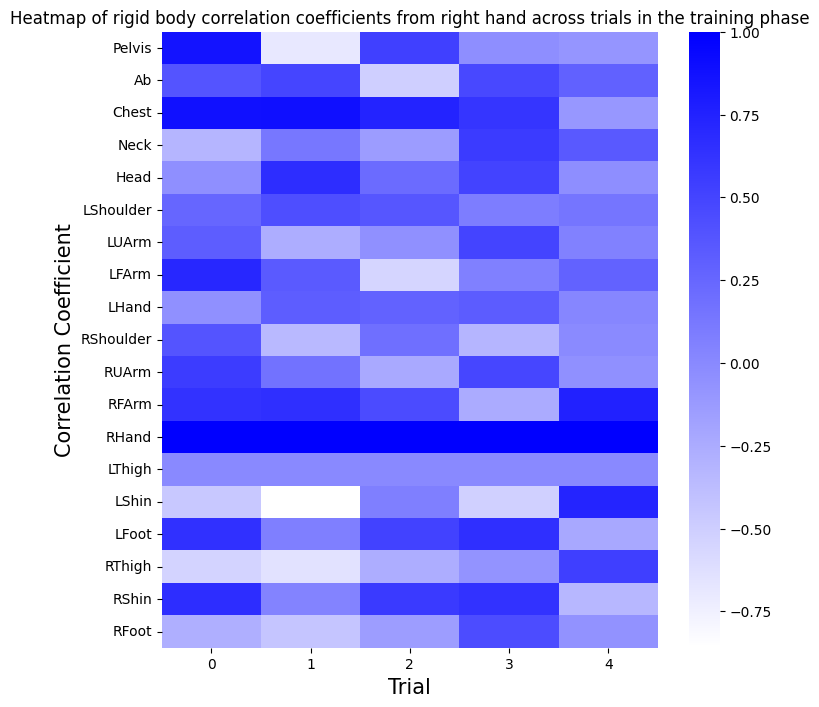

In [4]:
# Set parameters
trials = 5
rigidBodies = 19



# Pass the correct trial to the timestamp vector in seconds
timeStampVector =  timeStamps1  / 1000 #

correlationCoefficientsAcrossTrials = np.zeros((rigidBodies,trials))

# Analyse biggest PC of each rigid body trial 1 (training)
outputDictPCAVectorsTrial1 = extractPCAFromRigidBodies(rigidBodies1,cursorPos1)

# Analyse biggest PC of each rigid body trial 2 (training)
outputDictPCAVectorsTrial2 = extractPCAFromRigidBodies(rigidBodies2,cursorPos2)

# Analyse biggest PC of each rigid body trial 3 (training)
outputDictPCAVectorsTrial3 = extractPCAFromRigidBodies(rigidBodies3,cursorPos3)

# Analyse biggest PC of each rigid body trial 4 (training)
outputDictPCAVectorsTrial4 = extractPCAFromRigidBodies(rigidBodies4,cursorPos4)

# Analyse biggest PC of each rigid body trial 5 (test)
outputDictPCAVectorsTrial5 = extractPCAFromRigidBodies(rigidBodies5,cursorPos5)

# Collate all correlation coefficients to measure the evolution
correlationCoefficientsAcrossTrials[:,0] = outputDictPCAVectorsTrial1['rigidBodiesCorrCoeffs']
correlationCoefficientsAcrossTrials[:,1] = outputDictPCAVectorsTrial2['rigidBodiesCorrCoeffs']
correlationCoefficientsAcrossTrials[:,2] = outputDictPCAVectorsTrial3['rigidBodiesCorrCoeffs']
correlationCoefficientsAcrossTrials[:,3] = outputDictPCAVectorsTrial4['rigidBodiesCorrCoeffs']
correlationCoefficientsAcrossTrials[:,4] = outputDictPCAVectorsTrial5['rigidBodiesCorrCoeffs']

# # Plot rigid body correlation coefficients
# plt.plot(correlationCoefficientsAcrossTrials.transpose())
# plt.show()

# plt.imshow(correlationCoefficientsAcrossTrials, interpolation='nearest')
# plt.colorbar()  # To show the scale
# plt.show()

import seaborn as sns

from matplotlib.colors import LinearSegmentedColormap

# Define the colors
colors = ["#ffffff","#0000ff"]  # Blue to white to red

# Create the colormap
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors )
plt.figure(figsize=(8, 8)) 
sns.heatmap(correlationCoefficientsAcrossTrials, cmap = cmap, yticklabels = bodyParts)

plt.title("Heatmap of rigid body correlation coefficients from right hand across trials in the training phase")
plt.xlabel("Trial", fontsize = 15)
plt.ylabel("Correlation Coefficient", fontsize = 15)
plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trainingPhase")

Rigid Body: Pelvis, variance explained in PC1: 0.6159372021676462, and in PC2: 0.2889392901757367
Rigid Body: Ab, variance explained in PC1: 0.5390052920280409, and in PC2: 0.3688270873173704
Rigid Body: Chest, variance explained in PC1: 0.6610556292306408, and in PC2: 0.2806985445597057
Rigid Body: Neck, variance explained in PC1: 0.6335357410699675, and in PC2: 0.28635047502226313
Rigid Body: Head, variance explained in PC1: 0.6734183331356689, and in PC2: 0.2639022912169465
Rigid Body: LShoulder, variance explained in PC1: 0.556876177219925, and in PC2: 0.3131726609650463
Rigid Body: LUArm, variance explained in PC1: 0.6270752014647332, and in PC2: 0.27125806515014017
Rigid Body: LFArm, variance explained in PC1: 0.5803833388880298, and in PC2: 0.26195568273057157
Rigid Body: LHand, variance explained in PC1: 0.5655340328307074, and in PC2: 0.20438192206490532
Rigid Body: RShoulder, variance explained in PC1: 0.7790332753473493, and in PC2: 0.11263465081758961
Rigid Body: RUArm, var

/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_26338/2197401669.py:58: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trainingPhase")
/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_26338/2197401669.py:58: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trainingPhase")
/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_26338/2197401669.py:58: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trainingP

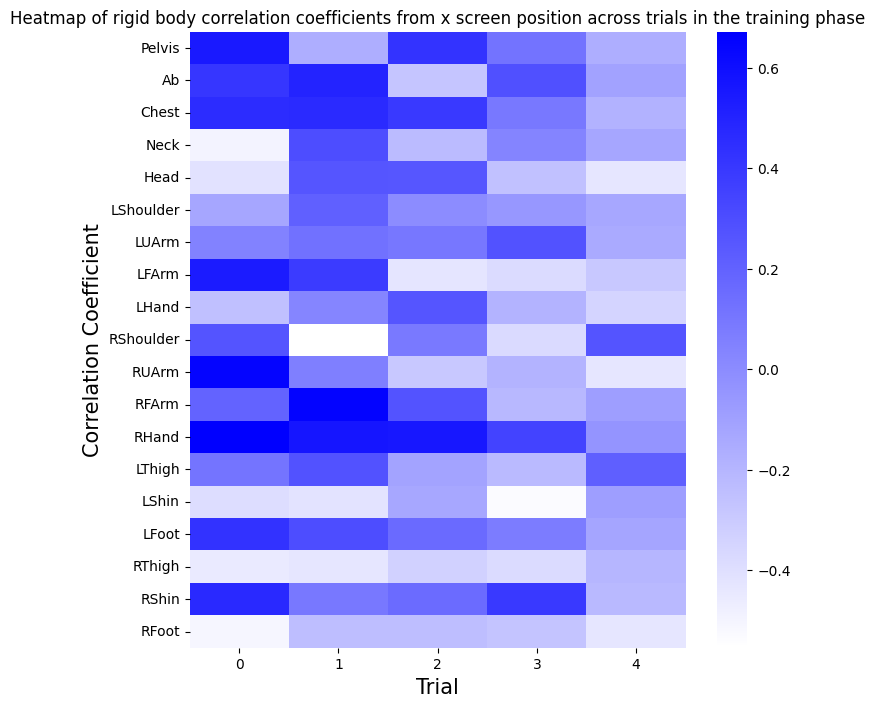

In [5]:
# Set parameters
trials = 5
rigidBodies = 19

# ASSESS CORRELATION TO X


# Pass the correct trial to the timestamp vector in seconds
timeStampVector =  timeStamps1  / 1000 #

correlationCoefficientsAcrossTrials = np.zeros((rigidBodies,trials))

# Analyse biggest PC of each rigid body trial 1 (training)
outputDictPCAVectorsTrial1 = extractPCAFromRigidBodies(rigidBodies1,cursorPos1,useCursor = 'x')

# Analyse biggest PC of each rigid body trial 2 (training)
outputDictPCAVectorsTrial2 = extractPCAFromRigidBodies(rigidBodies2,cursorPos2,useCursor = 'x')

# Analyse biggest PC of each rigid body trial 3 (training)
outputDictPCAVectorsTrial3 = extractPCAFromRigidBodies(rigidBodies3,cursorPos3,useCursor = 'x')

# Analyse biggest PC of each rigid body trial 4 (training)
outputDictPCAVectorsTrial4 = extractPCAFromRigidBodies(rigidBodies4,cursorPos4,useCursor = 'x')

# Analyse biggest PC of each rigid body trial 5 (test)
outputDictPCAVectorsTrial5 = extractPCAFromRigidBodies(rigidBodies5,cursorPos5,useCursor = 'x')

# Collate all correlation coefficients to measure the evolution
correlationCoefficientsAcrossTrials[:,0] = outputDictPCAVectorsTrial1['rigidBodiesCorrCoeffs']
correlationCoefficientsAcrossTrials[:,1] = outputDictPCAVectorsTrial2['rigidBodiesCorrCoeffs']
correlationCoefficientsAcrossTrials[:,2] = outputDictPCAVectorsTrial3['rigidBodiesCorrCoeffs']
correlationCoefficientsAcrossTrials[:,3] = outputDictPCAVectorsTrial4['rigidBodiesCorrCoeffs']
correlationCoefficientsAcrossTrials[:,4] = outputDictPCAVectorsTrial5['rigidBodiesCorrCoeffs']

# # Plot rigid body correlation coefficients
# plt.plot(correlationCoefficientsAcrossTrials.transpose())
# plt.show()

# plt.imshow(correlationCoefficientsAcrossTrials, interpolation='nearest')
# plt.colorbar()  # To show the scale
# plt.show()

import seaborn as sns

from matplotlib.colors import LinearSegmentedColormap

# Define the colors
colors = ["#ffffff","#0000ff"]  # Blue to white to red

# Create the colormap
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors )
plt.figure(figsize=(8, 8)) 
sns.heatmap(correlationCoefficientsAcrossTrials, cmap = cmap, yticklabels = bodyParts)

plt.title("Heatmap of rigid body correlation coefficients from x screen position across trials in the training phase")
plt.xlabel("Trial", fontsize = 15)
plt.ylabel("Correlation Coefficient", fontsize = 15)
plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trainingPhase")

Rigid Body: Pelvis, variance explained in PC1: 0.6159372021676465, and in PC2: 0.28893929017573655
Rigid Body: Ab, variance explained in PC1: 0.5390052920280415, and in PC2: 0.36882708731737085
Rigid Body: Chest, variance explained in PC1: 0.6610556292306414, and in PC2: 0.28069854455970566
Rigid Body: Neck, variance explained in PC1: 0.6335357410699687, and in PC2: 0.2863504750222632
Rigid Body: Head, variance explained in PC1: 0.6734183331356682, and in PC2: 0.26390229121694714
Rigid Body: LShoulder, variance explained in PC1: 0.5568761772199253, and in PC2: 0.31317266096504637
Rigid Body: LUArm, variance explained in PC1: 0.627075201464733, and in PC2: 0.27125806515013956
Rigid Body: LFArm, variance explained in PC1: 0.5803833388880293, and in PC2: 0.2619556827305713
Rigid Body: LHand, variance explained in PC1: 0.5655340328307081, and in PC2: 0.20438192206490574
Rigid Body: RShoulder, variance explained in PC1: 0.7790332753473485, and in PC2: 0.11263465081758947
Rigid Body: RUArm, 

/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_26338/2676363177.py:58: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trainingPhase")
/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_26338/2676363177.py:58: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trainingPhase")
/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_26338/2676363177.py:58: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trainingP

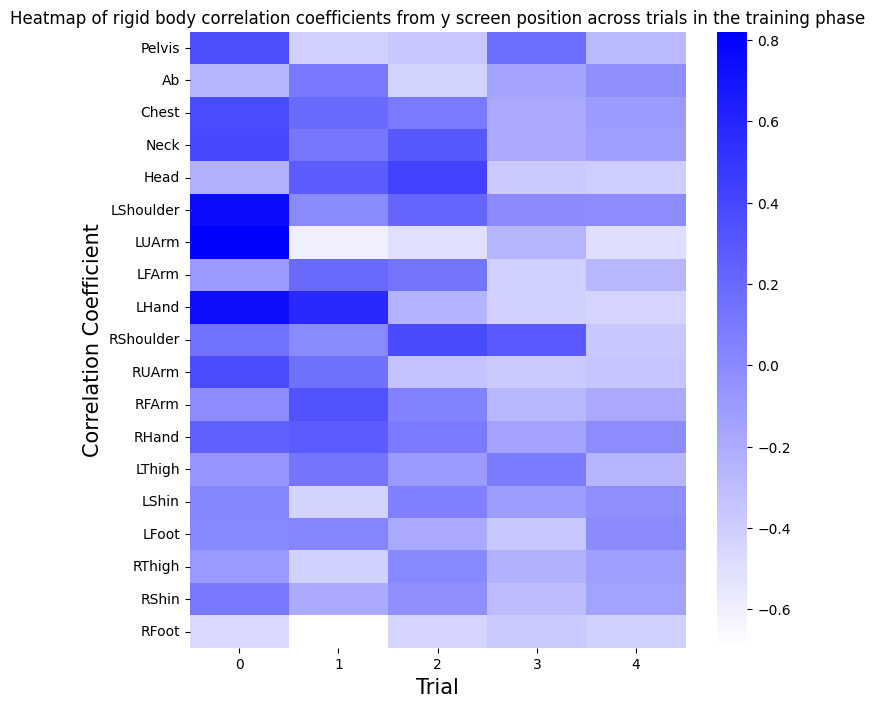

In [6]:
# Set parameters
trials = 5
rigidBodies = 19

# ASSESS CORRELATION TO X


# Pass the correct trial to the timestamp vector in seconds
timeStampVector =  timeStamps1  / 1000 #

correlationCoefficientsAcrossTrials = np.zeros((rigidBodies,trials))

# Analyse biggest PC of each rigid body trial 1 (training)
outputDictPCAVectorsTrial1 = extractPCAFromRigidBodies(rigidBodies1,cursorPos1,useCursor = 'y')

# Analyse biggest PC of each rigid body trial 2 (training)
outputDictPCAVectorsTrial2 = extractPCAFromRigidBodies(rigidBodies2,cursorPos2,useCursor = 'y')

# Analyse biggest PC of each rigid body trial 3 (training)
outputDictPCAVectorsTrial3 = extractPCAFromRigidBodies(rigidBodies3,cursorPos3,useCursor = 'y')

# Analyse biggest PC of each rigid body trial 4 (training)
outputDictPCAVectorsTrial4 = extractPCAFromRigidBodies(rigidBodies4,cursorPos4,useCursor = 'y')

# Analyse biggest PC of each rigid body trial 5 (test)
outputDictPCAVectorsTrial5 = extractPCAFromRigidBodies(rigidBodies5,cursorPos5,useCursor = 'y')

# Collate all correlation coefficients to measure the evolution
correlationCoefficientsAcrossTrials[:,0] = outputDictPCAVectorsTrial1['rigidBodiesCorrCoeffs']
correlationCoefficientsAcrossTrials[:,1] = outputDictPCAVectorsTrial2['rigidBodiesCorrCoeffs']
correlationCoefficientsAcrossTrials[:,2] = outputDictPCAVectorsTrial3['rigidBodiesCorrCoeffs']
correlationCoefficientsAcrossTrials[:,3] = outputDictPCAVectorsTrial4['rigidBodiesCorrCoeffs']
correlationCoefficientsAcrossTrials[:,4] = outputDictPCAVectorsTrial5['rigidBodiesCorrCoeffs']

# # Plot rigid body correlation coefficients
# plt.plot(correlationCoefficientsAcrossTrials.transpose())
# plt.show()

# plt.imshow(correlationCoefficientsAcrossTrials, interpolation='nearest')
# plt.colorbar()  # To show the scale
# plt.show()

import seaborn as sns

from matplotlib.colors import LinearSegmentedColormap

# Define the colors
colors = ["#ffffff","#0000ff"]  # Blue to white to red

# Create the colormap
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors )
plt.figure(figsize=(8, 8)) 
sns.heatmap(correlationCoefficientsAcrossTrials, cmap = cmap, yticklabels = bodyParts)

plt.title("Heatmap of rigid body correlation coefficients from y screen position across trials in the training phase")
plt.xlabel("Trial", fontsize = 15)
plt.ylabel("Correlation Coefficient", fontsize = 15)
plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trainingPhase")

Rigid Body: Pelvis, variance explained in PC1: 0.6152086059457897, and in PC2: 0.37315828452496536
Rigid Body: Ab, variance explained in PC1: 0.7583940084476025, and in PC2: 0.2281075377846508
Rigid Body: Chest, variance explained in PC1: 0.55138983121105, and in PC2: 0.36023394724077856
Rigid Body: Neck, variance explained in PC1: 0.755805855297513, and in PC2: 0.2202076196457216
Rigid Body: Head, variance explained in PC1: 0.753533277391105, and in PC2: 0.23695007868263215
Rigid Body: LShoulder, variance explained in PC1: 0.5304201205001413, and in PC2: 0.4147832391217434
Rigid Body: LUArm, variance explained in PC1: 0.8623480237777275, and in PC2: 0.12861106306168577
Rigid Body: LFArm, variance explained in PC1: 0.8331621230173053, and in PC2: 0.15504042484008032
Rigid Body: LHand, variance explained in PC1: 0.7467206122033327, and in PC2: 0.20588611844865454
Rigid Body: RShoulder, variance explained in PC1: 0.6919158755806629, and in PC2: 0.2839327001176924
Rigid Body: RUArm, varia

/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_26338/305315710.py:90: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trial " + trial)
/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_26338/305315710.py:90: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trial " + trial)
/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_26338/305315710.py:90: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trial " + 

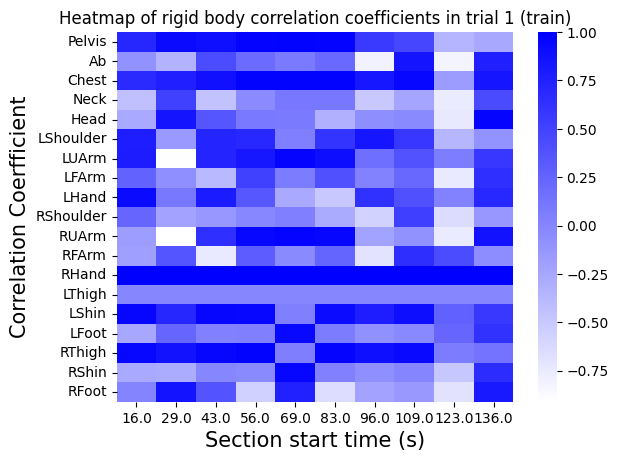

Rigid Body: Pelvis, variance explained in PC1: 0.851245755305066, and in PC2: 0.12192880583572108
Rigid Body: Ab, variance explained in PC1: 0.8405611164066742, and in PC2: 0.1404681431486046
Rigid Body: Chest, variance explained in PC1: 0.6833286898637687, and in PC2: 0.2579489820996823
Rigid Body: Neck, variance explained in PC1: 0.7240408412342537, and in PC2: 0.24331653990547766
Rigid Body: Head, variance explained in PC1: 0.5701391580227297, and in PC2: 0.378068094917278
Rigid Body: LShoulder, variance explained in PC1: 0.783336244153817, and in PC2: 0.1897147055227155
Rigid Body: LUArm, variance explained in PC1: 0.9142893055587721, and in PC2: 0.07304997341829067
Rigid Body: LFArm, variance explained in PC1: 0.8779321099685448, and in PC2: 0.1018593133023047
Rigid Body: LHand, variance explained in PC1: 0.7524782346031894, and in PC2: 0.22025525615243063
Rigid Body: RShoulder, variance explained in PC1: 0.7731632000436187, and in PC2: 0.16935718552437232
Rigid Body: RUArm, varia

/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_26338/305315710.py:90: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trial " + trial)
/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_26338/305315710.py:90: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trial " + trial)
/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_26338/305315710.py:90: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trial " + 

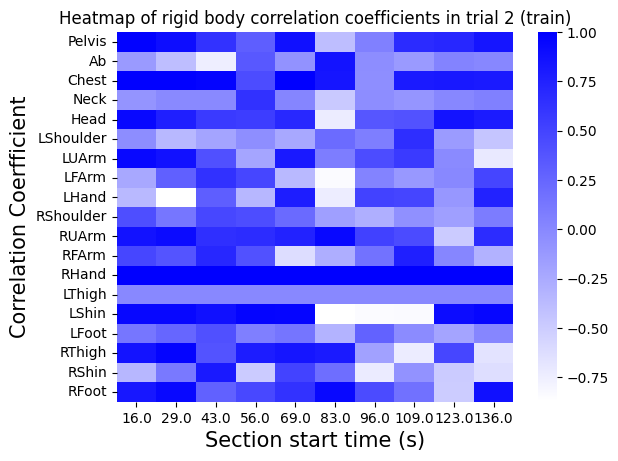

Rigid Body: Pelvis, variance explained in PC1: 0.739442114018966, and in PC2: 0.15746446076895673
Rigid Body: Ab, variance explained in PC1: 0.7191783339883173, and in PC2: 0.21627505330789745
Rigid Body: Chest, variance explained in PC1: 0.5765483711454849, and in PC2: 0.3533856160489449
Rigid Body: Neck, variance explained in PC1: 0.8207725744980022, and in PC2: 0.172552667268969
Rigid Body: Head, variance explained in PC1: 0.8661419263973376, and in PC2: 0.12884222166020154
Rigid Body: LShoulder, variance explained in PC1: 0.9263442854811655, and in PC2: 0.06695081604148911
Rigid Body: LUArm, variance explained in PC1: 0.8290093231701717, and in PC2: 0.08679052576817574
Rigid Body: LFArm, variance explained in PC1: 0.5849669536254763, and in PC2: 0.25080215348454354
Rigid Body: LHand, variance explained in PC1: 0.5016778566583099, and in PC2: 0.24730733897630525
Rigid Body: RShoulder, variance explained in PC1: 0.7638269991437162, and in PC2: 0.19142220247717384
Rigid Body: RUArm, v

/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_26338/305315710.py:90: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trial " + trial)
/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_26338/305315710.py:90: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trial " + trial)
/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_26338/305315710.py:90: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trial " + 

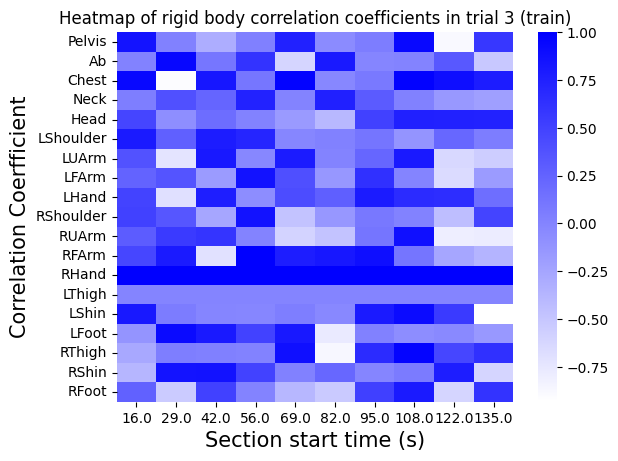

Rigid Body: Pelvis, variance explained in PC1: 0.7273394763563188, and in PC2: 0.1859124089228675
Rigid Body: Ab, variance explained in PC1: 0.7957539371770119, and in PC2: 0.16333310211612528
Rigid Body: Chest, variance explained in PC1: 0.8182867205113019, and in PC2: 0.1475915310082501
Rigid Body: Neck, variance explained in PC1: 0.7317438580426131, and in PC2: 0.21091028544116439
Rigid Body: Head, variance explained in PC1: 0.7881528563463667, and in PC2: 0.16375691198054443
Rigid Body: LShoulder, variance explained in PC1: 0.5712217334933151, and in PC2: 0.27166989872896763
Rigid Body: LUArm, variance explained in PC1: 0.8086337202681736, and in PC2: 0.1333548481259874
Rigid Body: LFArm, variance explained in PC1: 0.6241992431092162, and in PC2: 0.187298077293529
Rigid Body: LHand, variance explained in PC1: 0.6130634992499696, and in PC2: 0.2352529746915691
Rigid Body: RShoulder, variance explained in PC1: 0.5635748742987582, and in PC2: 0.22828412097208228
Rigid Body: RUArm, var

/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_26338/305315710.py:90: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trial " + trial)
/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_26338/305315710.py:90: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trial " + trial)
/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_26338/305315710.py:90: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trial " + 

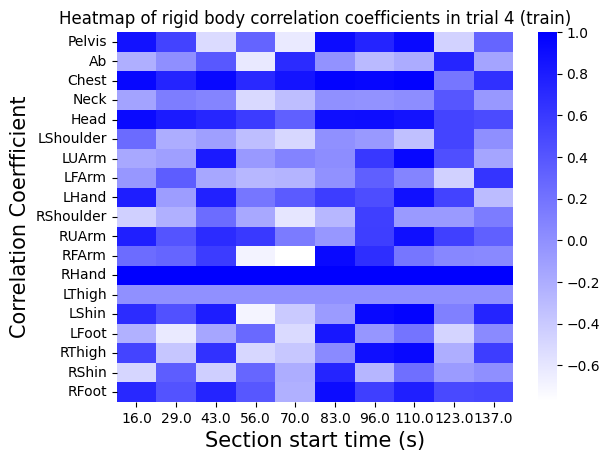

Rigid Body: Pelvis, variance explained in PC1: 0.7459565300883201, and in PC2: 0.24513514903975853
Rigid Body: Ab, variance explained in PC1: 0.6594679540070456, and in PC2: 0.2336947468250246
Rigid Body: Chest, variance explained in PC1: 0.713799272305649, and in PC2: 0.1458322576737693
Rigid Body: Neck, variance explained in PC1: 0.6045511071335277, and in PC2: 0.28924552495515216
Rigid Body: Head, variance explained in PC1: 0.5435667957979642, and in PC2: 0.38253056838757776
Rigid Body: LShoulder, variance explained in PC1: 0.5226922190167425, and in PC2: 0.3076631346895518
Rigid Body: LUArm, variance explained in PC1: 0.536406018166211, and in PC2: 0.37162500967710627
Rigid Body: LFArm, variance explained in PC1: 0.8473108236649466, and in PC2: 0.09445884466094591
Rigid Body: LHand, variance explained in PC1: 0.851635862472899, and in PC2: 0.07261915707913953
Rigid Body: RShoulder, variance explained in PC1: 0.8320064348518488, and in PC2: 0.15184294015943442
Rigid Body: RUArm, var

/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_26338/305315710.py:90: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trial " + trial)
/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_26338/305315710.py:90: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trial " + trial)
/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_26338/305315710.py:90: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trial " + 

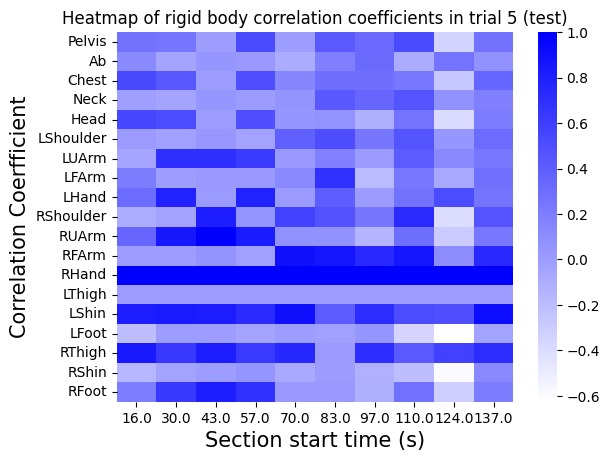

In [7]:
# Plot the correlation over a trial

plotCorrelationCoefficientVariationAcrossTrial(rigidBodies1,cursorPos1,trial = "1 (train)")
plt.show()
plotCorrelationCoefficientVariationAcrossTrial(rigidBodies2,cursorPos2,trial = "2 (train)")
plt.show()
plotCorrelationCoefficientVariationAcrossTrial(rigidBodies3,cursorPos3,trial = "3 (train)")
plt.show()
plotCorrelationCoefficientVariationAcrossTrial(rigidBodies4,cursorPos4,trial = "4 (train)")
plt.show()
plotCorrelationCoefficientVariationAcrossTrial(rigidBodies5,cursorPos5,trial = "5 (test)")
plt.show()

In [8]:
# Now look at learning over the decoder period



rigidBodiesE, cursorPosE,cursorVelE,goCuesE,targetHitsE,timeStampsE, minDofE,maxDofE,e,targetFailedAppearTimesE = processTrialData(saveGameLocation + "_usingDecoderE",DOFOffset)
rigidBodiesF, cursorPosF,cursorVelF,goCuesF,targetHitsF,timeStampsF, minDofF,maxDofF,f,targetFailedAppearTimesE = processTrialData(saveGameLocation + "_usingDecoderF",DOFOffset)
rigidBodiesG, cursorPosG,cursorVelG,goCuesG,targetHitsG,timeStampsG, minDofG,maxDofG,g,targetFailedAppearTimesE = processTrialData(saveGameLocation + "_usingDecoderG",DOFOffset)
rigidBodiesH, cursorPosH,cursorVelH,goCuesH,targetHitsH,timeStampsH, minDofH,maxDofH,h,targetFailedAppearTimesE = processTrialData(saveGameLocation + "_usingDecoderH",DOFOffset)
rigidBodiesI, cursorPosI,cursorVelI,goCuesI,targetHitsI,timeStampsI, minDofI,maxDofI,i,targetFailedAppearTimesE = processTrialData(saveGameLocation + "_usingDecoderI",DOFOffset)
rigidBodiesJ, cursorPosJ,cursorVelJ,goCuesJ,targetHitsJ,timeStampsJ, minDofJ,maxDofJ,j,targetFailedAppearTimesE = processTrialData(saveGameLocation + "_usingDecoderJ",DOFOffset)

/Users/ashwin/Documents/Y4 project Brain Human Interfaces/General 4th year Github repo/BrainMachineInterfaces/Experiment_pointer/DataAnalysis
/Users/ashwin/Documents/Y4 project Brain Human Interfaces/General 4th year Github repo/BrainMachineInterfaces/Experiment_pointer/DataAnalysis
/Users/ashwin/Documents/Y4 project Brain Human Interfaces/General 4th year Github repo/BrainMachineInterfaces/Experiment_pointer/DataAnalysis
/Users/ashwin/Documents/Y4 project Brain Human Interfaces/General 4th year Github repo/BrainMachineInterfaces/Experiment_pointer/DataAnalysis
/Users/ashwin/Documents/Y4 project Brain Human Interfaces/General 4th year Github repo/BrainMachineInterfaces/Experiment_pointer/DataAnalysis
/Users/ashwin/Documents/Y4 project Brain Human Interfaces/General 4th year Github repo/BrainMachineInterfaces/Experiment_pointer/DataAnalysis


Rigid Body: Pelvis, variance explained in PC1: 0.7938872614070047, and in PC2: 0.15546328924776712
Rigid Body: Ab, variance explained in PC1: 0.7324228296791864, and in PC2: 0.2144634884824567
Rigid Body: Chest, variance explained in PC1: 0.6151754486775669, and in PC2: 0.3156644741359804
Rigid Body: Neck, variance explained in PC1: 0.7434798296196616, and in PC2: 0.1849684353271778
Rigid Body: Head, variance explained in PC1: 0.6083539160714582, and in PC2: 0.34083477469798956
Rigid Body: LShoulder, variance explained in PC1: 0.6908453020901907, and in PC2: 0.22905909581719727
Rigid Body: LUArm, variance explained in PC1: 0.716525022395902, and in PC2: 0.22794107084208665
Rigid Body: LFArm, variance explained in PC1: 0.7483382917405171, and in PC2: 0.18633791704501163
Rigid Body: LHand, variance explained in PC1: 0.6807659214506776, and in PC2: 0.22761903685537535
Rigid Body: RShoulder, variance explained in PC1: 0.701242835519102, and in PC2: 0.20955581496478726
Rigid Body: RUArm, va

/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_26338/416490190.py:61: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trainingPhase")
/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_26338/416490190.py:61: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trainingPhase")
/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_26338/416490190.py:61: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trainingPhas

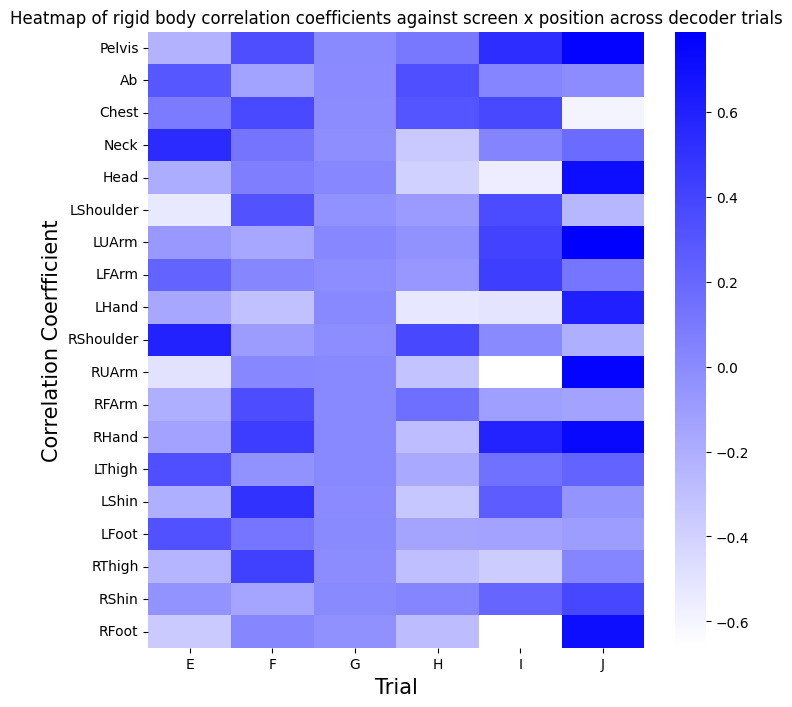

In [9]:
# Set parameters
trials = 6
rigidBodies = 19



# Pass the correct trial to the timestamp vector in seconds
timeStampVector =  timeStamps1  / 1000 #

correlationCoefficientsAcrossTrials = np.zeros((rigidBodies,trials))

# Analyse biggest PC of each rigid body trial E
outputDictPCAVectorsTrialE = extractPCAFromRigidBodies(rigidBodiesE,cursorPosE,useCursor = 'x')

# Analyse biggest PC of each rigid body trial F
outputDictPCAVectorsTrialF = extractPCAFromRigidBodies(rigidBodiesF,cursorPosF,useCursor = 'x')

# Analyse biggest PC of each rigid body trial G
outputDictPCAVectorsTrialG = extractPCAFromRigidBodies(rigidBodiesG,cursorPosG,useCursor = 'x')

# Analyse biggest PC of each rigid body trial H
outputDictPCAVectorsTrialH = extractPCAFromRigidBodies(rigidBodiesH,cursorPosH,useCursor = 'x')

# Analyse biggest PC of each rigid body trial I
outputDictPCAVectorsTrialI = extractPCAFromRigidBodies(rigidBodiesI,cursorPosI,useCursor = 'x')

# Analyse biggest PC of each rigid body trial J 
outputDictPCAVectorsTrialJ = extractPCAFromRigidBodies(rigidBodiesJ,cursorPosJ,useCursor = 'x')

# Collate all correlation coefficients to measure the evolution
correlationCoefficientsAcrossTrials[:,0] = outputDictPCAVectorsTrialE['rigidBodiesCorrCoeffs']
correlationCoefficientsAcrossTrials[:,1] = outputDictPCAVectorsTrialF['rigidBodiesCorrCoeffs']
correlationCoefficientsAcrossTrials[:,2] = outputDictPCAVectorsTrialG['rigidBodiesCorrCoeffs']
correlationCoefficientsAcrossTrials[:,3] = outputDictPCAVectorsTrialH['rigidBodiesCorrCoeffs']
correlationCoefficientsAcrossTrials[:,4] = outputDictPCAVectorsTrialI['rigidBodiesCorrCoeffs']
correlationCoefficientsAcrossTrials[:,5] = outputDictPCAVectorsTrialJ['rigidBodiesCorrCoeffs']

# # Plot rigid body correlation coefficients
# plt.plot(correlationCoefficientsAcrossTrials.transpose())
# plt.show()

# plt.imshow(correlationCoefficientsAcrossTrials, interpolation='nearest')
# plt.colorbar()  # To show the scale
# plt.show()

import seaborn as sns

from matplotlib.colors import LinearSegmentedColormap

# Define the colors
colors = ["#ffffff","#0000ff"]  # Blue to white to red
decoders = ['E','F','G','H','I','J']
# Create the colormap
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors )
plt.figure(figsize=(8, 8)) 
sns.heatmap(correlationCoefficientsAcrossTrials, cmap = cmap, yticklabels = bodyParts, xticklabels=decoders)

plt.title("Heatmap of rigid body correlation coefficients against screen x position across decoder trials")
plt.xlabel("Trial", fontsize = 15)
plt.ylabel("Correlation Coerfficient", fontsize = 15)
plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trainingPhase")

Rigid Body: Pelvis, variance explained in PC1: 0.7938872614070054, and in PC2: 0.15546328924776734
Rigid Body: Ab, variance explained in PC1: 0.7324228296791866, and in PC2: 0.21446348848245622
Rigid Body: Chest, variance explained in PC1: 0.6151754486775667, and in PC2: 0.3156644741359799
Rigid Body: Neck, variance explained in PC1: 0.7434798296196614, and in PC2: 0.1849684353271778
Rigid Body: Head, variance explained in PC1: 0.6083539160714575, and in PC2: 0.3408347746979903
Rigid Body: LShoulder, variance explained in PC1: 0.6908453020901918, and in PC2: 0.22905909581719694
Rigid Body: LUArm, variance explained in PC1: 0.7165250223959017, and in PC2: 0.22794107084208665
Rigid Body: LFArm, variance explained in PC1: 0.7483382917405162, and in PC2: 0.18633791704501107
Rigid Body: LHand, variance explained in PC1: 0.6807659214506782, and in PC2: 0.22761903685537546
Rigid Body: RShoulder, variance explained in PC1: 0.7012428355191028, and in PC2: 0.209555814964787
Rigid Body: RUArm, va

/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_26338/3647210380.py:61: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trainingPhase")
/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_26338/3647210380.py:61: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trainingPhase")
/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_26338/3647210380.py:61: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trainingP

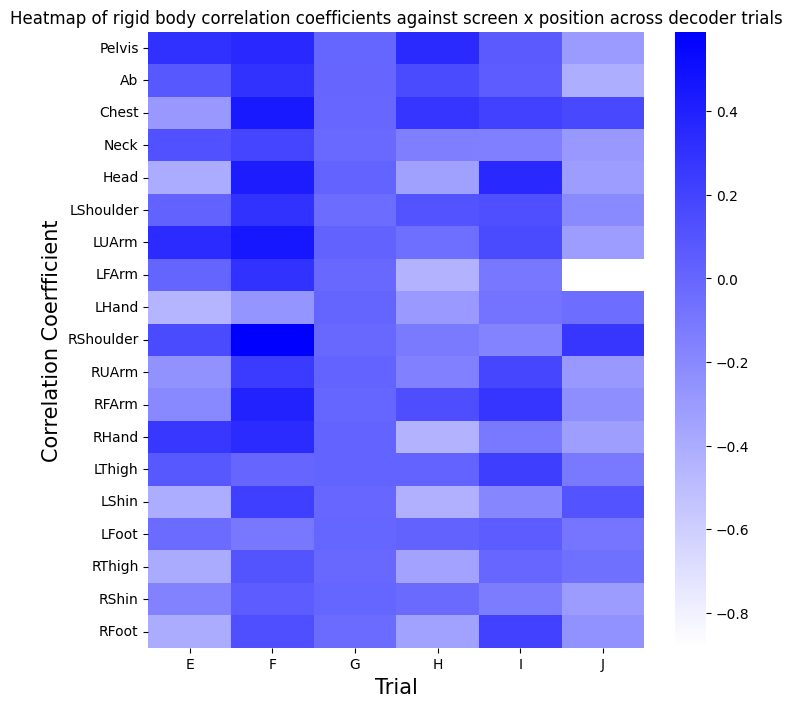

In [10]:
# Set parameters
trials = 6
rigidBodies = 19



# Pass the correct trial to the timestamp vector in seconds
timeStampVector =  timeStamps1  / 1000 #

correlationCoefficientsAcrossTrials = np.zeros((rigidBodies,trials))

# Analyse biggest PC of each rigid body trial E
outputDictPCAVectorsTrialE = extractPCAFromRigidBodies(rigidBodiesE,cursorPosE,useCursor = 'y')

# Analyse biggest PC of each rigid body trial F
outputDictPCAVectorsTrialF = extractPCAFromRigidBodies(rigidBodiesF,cursorPosF,useCursor = 'y')

# Analyse biggest PC of each rigid body trial G
outputDictPCAVectorsTrialG = extractPCAFromRigidBodies(rigidBodiesG,cursorPosG,useCursor = 'y')

# Analyse biggest PC of each rigid body trial H
outputDictPCAVectorsTrialH = extractPCAFromRigidBodies(rigidBodiesH,cursorPosH,useCursor = 'y')

# Analyse biggest PC of each rigid body trial I
outputDictPCAVectorsTrialI = extractPCAFromRigidBodies(rigidBodiesI,cursorPosI,useCursor = 'y')

# Analyse biggest PC of each rigid body trial J 
outputDictPCAVectorsTrialJ = extractPCAFromRigidBodies(rigidBodiesJ,cursorPosJ,useCursor = 'y')

# Collate all correlation coefficients to measure the evolution
correlationCoefficientsAcrossTrials[:,0] = outputDictPCAVectorsTrialE['rigidBodiesCorrCoeffs']
correlationCoefficientsAcrossTrials[:,1] = outputDictPCAVectorsTrialF['rigidBodiesCorrCoeffs']
correlationCoefficientsAcrossTrials[:,2] = outputDictPCAVectorsTrialG['rigidBodiesCorrCoeffs']
correlationCoefficientsAcrossTrials[:,3] = outputDictPCAVectorsTrialH['rigidBodiesCorrCoeffs']
correlationCoefficientsAcrossTrials[:,4] = outputDictPCAVectorsTrialI['rigidBodiesCorrCoeffs']
correlationCoefficientsAcrossTrials[:,5] = outputDictPCAVectorsTrialJ['rigidBodiesCorrCoeffs']

# # Plot rigid body correlation coefficients
# plt.plot(correlationCoefficientsAcrossTrials.transpose())
# plt.show()

# plt.imshow(correlationCoefficientsAcrossTrials, interpolation='nearest')
# plt.colorbar()  # To show the scale
# plt.show()

import seaborn as sns

from matplotlib.colors import LinearSegmentedColormap

# Define the colors
colors = ["#ffffff","#0000ff"]  # Blue to white to red
decoders = ['E','F','G','H','I','J']
# Create the colormap
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors )
plt.figure(figsize=(8, 8)) 
sns.heatmap(correlationCoefficientsAcrossTrials, cmap = cmap, yticklabels = bodyParts, xticklabels=decoders)

plt.title("Heatmap of rigid body correlation coefficients against screen x position across decoder trials")
plt.xlabel("Trial", fontsize = 15)
plt.ylabel("Correlation Coerfficient", fontsize = 15)
plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trainingPhase")